In [4]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from collections import  defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import classification_report
from src.wrapped import Wrapped
from src.analysesV02 import Analytics
from src.train import *

# Importar dados

In [5]:
ac = Analytics()

wp = Wrapped(
    '../data/row/',
    '../data/processed/',
    '../data/files/'
)

In [6]:
# dataset
df = wp.load_data('df_instrumentos_features_selecionadas').drop(columns=['file_name'])
df.columns

Index(['tonnetz0', 'tonnetz1', 'chroma1', 'chroma2', 'chroma3', 'chroma4',
       'chroma5', 'chroma6', 'chroma7', 'mfcc0', 'mfcc1', 'mfcc2', 'mfcc3',
       'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10',
       'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17',
       'mfcc18', 'mfcc19', 'chroma8', 'chroma9', 'chroma10', 'chroma11',
       'chroma12', 'spectral_band2', 'spectral_band3', 'spectral_band4',
       'spectral_centroid', 'spectral_onset', 'spectral_rolloff', 'spectogram',
       'mel_spectogram', 'zero_crossing_rate', 'zero_crossing', 'instrumento'],
      dtype='object')

# Pré Processamento

In [7]:
le = LabelEncoder()

df['label_inst'] = le.fit_transform(df.instrumento)
df.head()

,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,mfcc0,...,spectral_band4,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,instrumento,label_inst
0,0.010380,0.038218,0.513887,0.581963,0.434641,0.293949,0.317826,0.271148,0.548258,-24.170067,...,3409.640722,2600.055158,1.098243,5260.821321,-44.640682,-30.202150,0.149672,33095,accordion,0
1,0.084643,-0.035337,0.175587,0.429345,0.840043,0.384524,0.282545,0.346341,0.482365,-90.556145,...,3516.595715,2385.271420,1.360742,5225.124166,-46.575737,-59.323132,0.112181,24785,accordion,0
2,-0.030127,0.082404,0.453814,0.219808,0.228484,0.446050,0.178916,0.250981,0.327460,-106.124260,...,3256.491175,2069.850731,1.343197,4287.155824,-56.276707,-71.512909,0.096007,21230,accordion,0
3,0.157274,-0.066099,0.209729,0.338755,0.660264,0.256625,0.275209,0.180417,0.399448,-66.319801,...,3855.791675,2903.979876,1.218963,6751.133809,-42.723160,-44.649315,0.144010,31836,accordion,0
4,-0.049096,-0.029067,0.484400,0.334572,0.441629,0.679485,0.382958,0.326033,0.205775,-226.263824,...,2883.225952,1251.374287,1.339527,2263.034730,-62.227947,-78.196365,0.059804,13214,accordion,0


In [8]:
# ver classe por instrumento 
keys = le.classes_
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))
print(dictionary)

{'accordion': 0, 'banjo': 1, 'bass': 2, 'cello': 3, 'clarinet': 4, 'cymbals': 5, 'drums': 6, 'flute': 7, 'guitar': 8, 'mallet_percussion': 9, 'mandolin': 10, 'organ': 11, 'piano': 12, 'saxophone': 13, 'synthesizer': 14, 'trombone': 15, 'trumpet': 16, 'ukulele': 17, 'violin': 18, 'voice': 19}


#### instrumentos por classe
- corda: cello, guitar, violin, bass, banjo, mandolin e ukulele
- percusao: mallet_percussion, drums e cymbals
- sopro: clarinet, trombone, flute, trumpet, saxophone
- aerofone: accordion, organ, piano 

In [9]:
dict_cat_inst = {
    'aerofone': ["accordion", "organ", "piano"],
    'percusao': ["mallet_percussion", "drums", "cymbals"],
    'sopro': ["clarinet", "trombone", "flute", "trumpet", "saxophone"],
    'corda': ["cello", "guitar", "violin", "bass", "banjo", "mandolin", "ukulele"]
}

In [10]:
df.instrumento.unique()

array(['accordion', 'banjo', 'bass', 'cello', 'clarinet', 'cymbals',
       'drums', 'flute', 'guitar', 'mallet_percussion', 'mandolin',
       'organ', 'piano', 'saxophone', 'synthesizer', 'trombone',
       'trumpet', 'ukulele', 'violin', 'voice'], dtype=object)

In [11]:
df_aerofone = df[df['instrumento'].isin(dict_cat_inst['aerofone'])]
df_aerofone.insert(0, 'cat_inst', 'aerofone')

df_percusao = df[df['instrumento'].isin(dict_cat_inst['percusao'])]
df_percusao.insert(0, 'cat_inst', 'percusao')

df_sopro = df[df['instrumento'].isin(dict_cat_inst['sopro'])]
df_sopro.insert(0, 'cat_inst', 'sopro')

df_corda = df[df['instrumento'].isin(dict_cat_inst['corda'])]
df_corda.insert(0, 'cat_inst', 'corda')

df_cat_inst = pd.concat([df_aerofone, df_percusao, df_sopro, df_corda])
df_cat_inst

,cat_inst,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,...,spectral_band4,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,instrumento,label_inst
0,aerofone,0.010380,0.038218,0.513887,0.581963,0.434641,0.293949,0.317826,0.271148,0.548258,...,3409.640722,2600.055158,1.098243,5260.821321,-44.640682,-30.202150,0.149672,33095,accordion,0
1,aerofone,0.084643,-0.035337,0.175587,0.429345,0.840043,0.384524,0.282545,0.346341,0.482365,...,3516.595715,2385.271420,1.360742,5225.124166,-46.575737,-59.323132,0.112181,24785,accordion,0
2,aerofone,-0.030127,0.082404,0.453814,0.219808,0.228484,0.446050,0.178916,0.250981,0.327460,...,3256.491175,2069.850731,1.343197,4287.155824,-56.276707,-71.512909,0.096007,21230,accordion,0
3,aerofone,0.157274,-0.066099,0.209729,0.338755,0.660264,0.256625,0.275209,0.180417,0.399448,...,3855.791675,2903.979876,1.218963,6751.133809,-42.723160,-44.649315,0.144010,31836,accordion,0
4,aerofone,-0.049096,-0.029067,0.484400,0.334572,0.441629,0.679485,0.382958,0.326033,0.205775,...,2883.225952,1251.374287,1.339527,2263.034730,-62.227947,-78.196365,0.059804,13214,accordion,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8019,corda,0.051950,0.691044,0.773323,0.582712,0.532384,0.274606,0.127275,0.109617,0.158079,...,1906.686246,658.017342,1.227272,1367.932950,-35.302883,-68.164001,0.019043,4212,violin,18
8020,corda,0.015595,-0.058762,0.120028,0.238263,0.234643,0.267743,0.228591,0.260930,0.267262,...,3383.563150,3573.542978,1.354204,6552.813508,-43.596504,-73.498703,0.230540,50962,violin,18
8021,corda,0.093624,-0.031124,0.253249,0.321181,0.309254,0.265595,0.265015,0.155659,0.181344,...,3174.287104,1421.358194,1.173742,2751.578644,-48.512993,-66.277359,0.065123,14407,violin,18
8022,corda,0.004588,-0.009204,0.124913,0.174113,0.185558,0.169614,0.149416,0.075544,0.081894,...,3232.221409,3720.081212,1.332893,6207.732687,-37.720039,-72.552101,0.241853,53491,violin,18


In [12]:
print('Sem voice e synthesizer:', df.shape[0] -  (df[df.instrumento == 'voice'].shape[0] + df[df.instrumento == 'synthesizer'].shape[0]))

Sem voice e synthesizer: 7649


In [13]:
df_cat_inst['label_cat_inst'] = le.fit_transform(df_cat_inst.cat_inst)
df_cat_inst

,cat_inst,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,...,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,instrumento,label_inst,label_cat_inst
0,aerofone,0.010380,0.038218,0.513887,0.581963,0.434641,0.293949,0.317826,0.271148,0.548258,...,2600.055158,1.098243,5260.821321,-44.640682,-30.202150,0.149672,33095,accordion,0,0
1,aerofone,0.084643,-0.035337,0.175587,0.429345,0.840043,0.384524,0.282545,0.346341,0.482365,...,2385.271420,1.360742,5225.124166,-46.575737,-59.323132,0.112181,24785,accordion,0,0
2,aerofone,-0.030127,0.082404,0.453814,0.219808,0.228484,0.446050,0.178916,0.250981,0.327460,...,2069.850731,1.343197,4287.155824,-56.276707,-71.512909,0.096007,21230,accordion,0,0
3,aerofone,0.157274,-0.066099,0.209729,0.338755,0.660264,0.256625,0.275209,0.180417,0.399448,...,2903.979876,1.218963,6751.133809,-42.723160,-44.649315,0.144010,31836,accordion,0,0
4,aerofone,-0.049096,-0.029067,0.484400,0.334572,0.441629,0.679485,0.382958,0.326033,0.205775,...,1251.374287,1.339527,2263.034730,-62.227947,-78.196365,0.059804,13214,accordion,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8019,corda,0.051950,0.691044,0.773323,0.582712,0.532384,0.274606,0.127275,0.109617,0.158079,...,658.017342,1.227272,1367.932950,-35.302883,-68.164001,0.019043,4212,violin,18,1
8020,corda,0.015595,-0.058762,0.120028,0.238263,0.234643,0.267743,0.228591,0.260930,0.267262,...,3573.542978,1.354204,6552.813508,-43.596504,-73.498703,0.230540,50962,violin,18,1
8021,corda,0.093624,-0.031124,0.253249,0.321181,0.309254,0.265595,0.265015,0.155659,0.181344,...,1421.358194,1.173742,2751.578644,-48.512993,-66.277359,0.065123,14407,violin,18,1
8022,corda,0.004588,-0.009204,0.124913,0.174113,0.185558,0.169614,0.149416,0.075544,0.081894,...,3720.081212,1.332893,6207.732687,-37.720039,-72.552101,0.241853,53491,violin,18,1


# Baseline

- Remover Outliers

In [17]:
knn_pred_cat_inst = ac.detected_outilers_knn(dataframe=df_cat_inst, neighbors=5, algorithm="auto", metric="euclidean")

- Plot

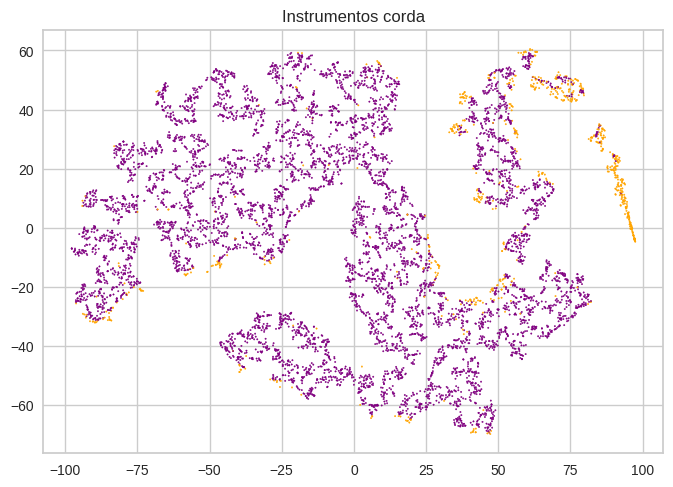

In [18]:
ac.graphic_anomalies(df_cat_inst, knn_pred_cat_inst["predictions"],'Instrumentos corda')

In [ ]:
# remover outilers do dataframe
new_df = show_outilers(df_cat_inst, knn_pred_cat_inst["predictions"])

- Split

In [ ]:
X = new_df.drop(columns=["label_inst", "label_cat_inst"])
y = new_df.label_cat_inst

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


- Treinamento

In [ ]:
model = LGBMClassifier()
model.fit(X_train, y_train)
predict = model.predict(X_test)
print(f'Acuracia {model}: {accuracy_score(y_test, predict)}')

Acuracia LGBMClassifier(): 0.5217812197483059


- Validação Cruzada

In [ ]:
train_models(
    X = new_df.drop(columns=["label_inst", "label_cat_inst"]),
    y = new_df.label_cat_inst.to_frame()
)

Acuracia do modelo GaussianNB() do Fold 0: 0.37400145243282495
Acuracia do modelo GaussianNB() do Fold 1: 0.4095860566448802
Acuracia do modelo GaussianNB() do Fold 2: 0.41830065359477125
Acuracia do modelo GaussianNB() do Fold 3: 0.38344226579520696
Acuracia do modelo GaussianNB() do Fold 4: 0.30886627906976744
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.33042846768336964
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.3674655047204067
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.3805374001452433
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.3609295570079884
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.345203488372093
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.3064633260711692
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.3522149600580973
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.3805374001452433
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.3442265795206972
Acuracia do modelo DecisionTre

{'Naive Bayes': 0.37883934150749016,
 'KNN': 0.35691288358582024,
 'Arvore de Decisão': 0.33628147641485534,
 'Floresta Aleatoria': 0.4444958495887589,
 'HistGradientBoosting': 0.4450769282734627,
 'LIGHTGBM': 0.45117967945145326,
 'MLP': 0.32742290283899955,
 'XGB': 0.4450774560470183,
 'SVC': 0.37186988059651077}

- Matriz de Confusão

In [ ]:
# ver classe por categoria instrumento 
keys = le.classes_
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))
print(dictionary)

{'aerofone': 0, 'corda': 1, 'percusao': 2, 'sopro': 3}


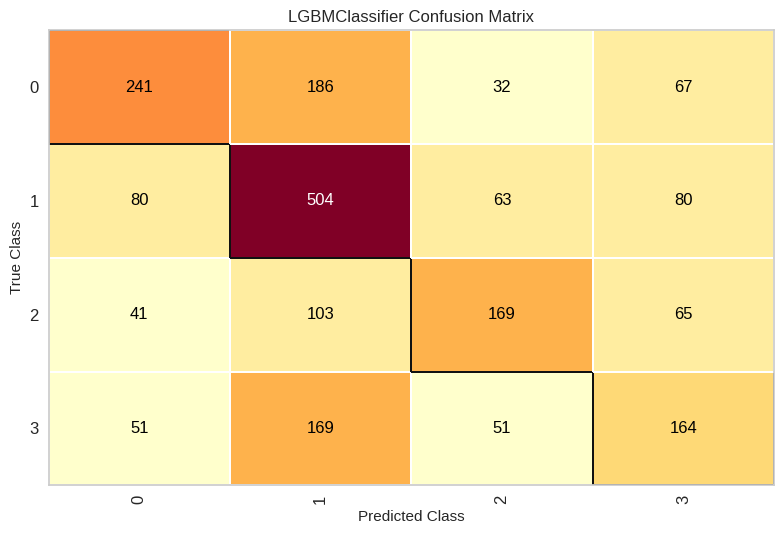

<AxesSubplot: title={'center': 'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
cm = ConfusionMatrix(model, classes=[0,1,2,3])

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

cm.show()

obs:. Pelos numeros da validação cruzada percebe a dificuldade não dizer quando se tem por exemplo um instrumento de corda mas sim quando não tem um instrumento de corda

In [ ]:
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.58      0.46      0.51       526
           1       0.52      0.69      0.60       727
           2       0.54      0.45      0.49       378
           3       0.44      0.38      0.40       435

    accuracy                           0.52      2066
   macro avg       0.52      0.49      0.50      2066
weighted avg       0.52      0.52      0.52      2066



# Experiementos com instrumentos par a par

### Combinação em par de categorias de instrumentos:

- aerofone e corda
- aerofone e sopro
- aerofone e percusão
- sopro e percusão
- sopro e corda
- percusão e corda

### Aerofone e corda

In [ ]:
df_aerofone_corda = df_cat_inst[df_cat_inst["cat_inst"].isin(["aerofone", "corda"])]
df_aerofone_corda["label_cat_inst"] = le.fit_transform(df_aerofone_corda.cat_inst)
df_aerofone_corda

,cat_inst,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,...,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,instrumento,label_inst,label_cat_inst
0,aerofone,0.010380,0.038218,0.513887,0.581963,0.434641,0.293949,0.317826,0.271148,0.548258,...,2600.055158,1.098243,5260.821321,-44.640682,-30.202150,0.149672,33095,accordion,0,0
1,aerofone,0.084643,-0.035337,0.175587,0.429345,0.840043,0.384524,0.282545,0.346341,0.482365,...,2385.271420,1.360742,5225.124166,-46.575737,-59.323132,0.112181,24785,accordion,0,0
2,aerofone,-0.030127,0.082404,0.453814,0.219808,0.228484,0.446050,0.178916,0.250981,0.327460,...,2069.850731,1.343197,4287.155824,-56.276707,-71.512909,0.096007,21230,accordion,0,0
3,aerofone,0.157274,-0.066099,0.209729,0.338755,0.660264,0.256625,0.275209,0.180417,0.399448,...,2903.979876,1.218963,6751.133809,-42.723160,-44.649315,0.144010,31836,accordion,0,0
4,aerofone,-0.049096,-0.029067,0.484400,0.334572,0.441629,0.679485,0.382958,0.326033,0.205775,...,1251.374287,1.339527,2263.034730,-62.227947,-78.196365,0.059804,13214,accordion,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8019,corda,0.051950,0.691044,0.773323,0.582712,0.532384,0.274606,0.127275,0.109617,0.158079,...,658.017342,1.227272,1367.932950,-35.302883,-68.164001,0.019043,4212,violin,18,1
8020,corda,0.015595,-0.058762,0.120028,0.238263,0.234643,0.267743,0.228591,0.260930,0.267262,...,3573.542978,1.354204,6552.813508,-43.596504,-73.498703,0.230540,50962,violin,18,1
8021,corda,0.093624,-0.031124,0.253249,0.321181,0.309254,0.265595,0.265015,0.155659,0.181344,...,1421.358194,1.173742,2751.578644,-48.512993,-66.277359,0.065123,14407,violin,18,1
8022,corda,0.004588,-0.009204,0.124913,0.174113,0.185558,0.169614,0.149416,0.075544,0.081894,...,3720.081212,1.332893,6207.732687,-37.720039,-72.552101,0.241853,53491,violin,18,1


- Tratar outilers

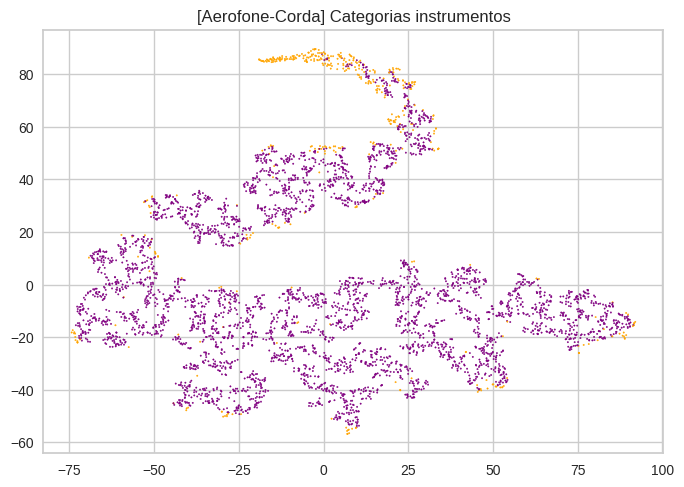

In [ ]:
graphic_anomalies(df_aerofone_corda.drop(columns=["instrumento", "cat_inst"]), '[Aerofone-Corda] Categorias instrumentos')

In [ ]:
df_aerofone_corda = remove_outilers(df_aerofone_corda.drop(columns=["instrumento", "cat_inst"]))
df_aerofone_corda

,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,mfcc0,...,spectral_band4,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,label_inst,label_cat_inst
0,0.010380,0.038218,0.513887,0.581963,0.434641,0.293949,0.317826,0.271148,0.548258,-24.170067,...,3409.640722,2600.055158,1.098243,5260.821321,-44.640682,-30.202150,0.149672,33095,0,0
1,0.084643,-0.035337,0.175587,0.429345,0.840043,0.384524,0.282545,0.346341,0.482365,-90.556145,...,3516.595715,2385.271420,1.360742,5225.124166,-46.575737,-59.323132,0.112181,24785,0,0
2,-0.030127,0.082404,0.453814,0.219808,0.228484,0.446050,0.178916,0.250981,0.327460,-106.124260,...,3256.491175,2069.850731,1.343197,4287.155824,-56.276707,-71.512909,0.096007,21230,0,0
4,-0.049096,-0.029067,0.484400,0.334572,0.441629,0.679485,0.382958,0.326033,0.205775,-226.263824,...,2883.225952,1251.374287,1.339527,2263.034730,-62.227947,-78.196365,0.059804,13214,0,0
5,-0.180964,0.569503,0.371429,0.329753,0.127768,0.165817,0.210350,0.864152,0.316520,-139.586807,...,3055.207315,1213.792172,0.863256,2477.767229,-66.244644,-79.955254,0.051793,11451,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8015,0.155398,0.202623,0.279203,0.175173,0.329897,0.101118,0.119236,0.150895,0.161468,-106.568298,...,3026.877791,2266.961445,1.172216,4213.738093,-42.284138,-79.955719,0.133785,29606,18,1
8018,0.181463,-0.109062,0.259089,0.054198,0.135665,0.120070,0.198278,0.268761,0.094458,-233.943954,...,2498.332214,1356.828177,0.969832,2408.271439,-62.397167,-78.355164,0.083315,18430,18,1
8019,0.051950,0.691044,0.773323,0.582712,0.532384,0.274606,0.127275,0.109617,0.158079,-260.673492,...,1906.686246,658.017342,1.227272,1367.932950,-35.302883,-68.164001,0.019043,4212,18,1
8021,0.093624,-0.031124,0.253249,0.321181,0.309254,0.265595,0.265015,0.155659,0.181344,-128.199768,...,3174.287104,1421.358194,1.173742,2751.578644,-48.512993,-66.277359,0.065123,14407,18,1


- Treinamento de modelo

In [ ]:
train_models(
    X= df_aerofone_corda.drop(columns=["label_inst", "label_cat_inst"]),
    y= df_aerofone_corda.label_cat_inst.to_frame()
)

Acuracia do modelo GaussianNB() do Fold 0: 0.5415117719950434
Acuracia do modelo GaussianNB() do Fold 1: 0.4770755885997522
Acuracia do modelo GaussianNB() do Fold 2: 0.4919454770755886
Acuracia do modelo GaussianNB() do Fold 3: 0.7258064516129032
Acuracia do modelo GaussianNB() do Fold 4: 0.5992555831265509
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.5799256505576208
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.5885997521685254
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.5712515489467163
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.6501240694789082
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.6364764267990074
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.5576208178438662
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.6171003717472119
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.5613382899628253
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.6588089330024814
Acuracia do modelo DecisionTreeCla

{'Naive Bayes': 0.5671189744819676,
 'KNN': 0.6052754895901555,
 'Arvore de Decisão': 0.6042838562085475,
 'Floresta Aleatoria': 0.6687661620867041,
 'HistGradientBoosting': 0.6655363583532429,
 'LIGHTGBM': 0.6670245771337029,
 'MLP': 0.6409850532407193,
 'XGB': 0.664048447056002,
 'SVC': 0.5923648841864455}

- Matrix de Confusão

In [ ]:
keys = le.classes_
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))
print(dictionary)

{'aerofone': 0, 'corda': 1}


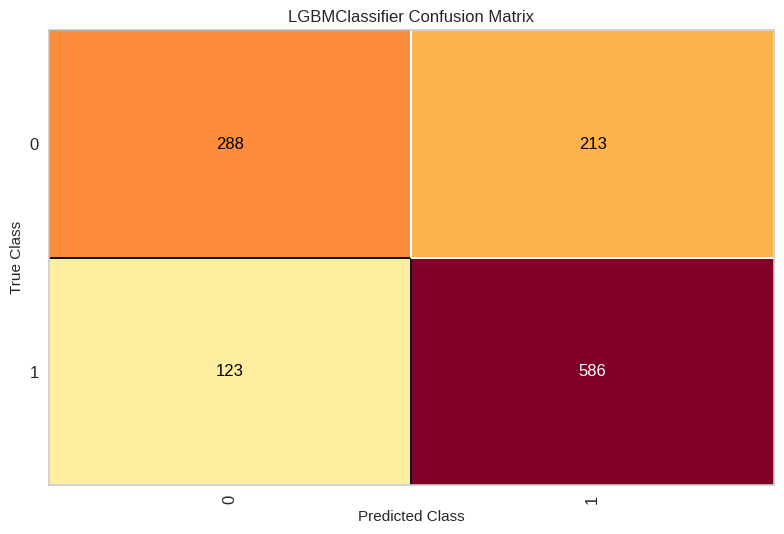

<AxesSubplot: title={'center': 'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
X = df_aerofone_corda.drop(columns=["label_inst", "label_cat_inst"])
y = df_aerofone_corda.label_cat_inst

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

cm = ConfusionMatrix(LGBMClassifier(), classes=[0,1])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

### Aerofone e sopro

In [ ]:
df_aerofone_sopro = df_cat_inst[df_cat_inst["cat_inst"].isin(["aerofone", "sopro"])]
df_aerofone_sopro["label_cat_inst"] = le.fit_transform(df_aerofone_sopro.cat_inst)
df_aerofone_sopro

,cat_inst,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,...,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,instrumento,label_inst,label_cat_inst
0,aerofone,0.010380,0.038218,0.513887,0.581963,0.434641,0.293949,0.317826,0.271148,0.548258,...,2600.055158,1.098243,5260.821321,-44.640682,-30.202150,0.149672,33095,accordion,0,0
1,aerofone,0.084643,-0.035337,0.175587,0.429345,0.840043,0.384524,0.282545,0.346341,0.482365,...,2385.271420,1.360742,5225.124166,-46.575737,-59.323132,0.112181,24785,accordion,0,0
2,aerofone,-0.030127,0.082404,0.453814,0.219808,0.228484,0.446050,0.178916,0.250981,0.327460,...,2069.850731,1.343197,4287.155824,-56.276707,-71.512909,0.096007,21230,accordion,0,0
3,aerofone,0.157274,-0.066099,0.209729,0.338755,0.660264,0.256625,0.275209,0.180417,0.399448,...,2903.979876,1.218963,6751.133809,-42.723160,-44.649315,0.144010,31836,accordion,0,0
4,aerofone,-0.049096,-0.029067,0.484400,0.334572,0.441629,0.679485,0.382958,0.326033,0.205775,...,1251.374287,1.339527,2263.034730,-62.227947,-78.196365,0.059804,13214,accordion,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7161,sopro,0.031326,0.036042,0.281165,0.467478,0.383710,0.385898,0.358991,0.379168,0.286116,...,896.653459,1.242603,1782.859289,-42.632786,-42.830780,0.041767,9231,trumpet,16,1
7162,sopro,0.024069,-0.064162,0.038717,0.051984,0.156484,0.528343,0.865360,0.228249,0.063890,...,1280.731144,1.535133,1930.644010,-52.891537,-79.643761,0.078466,17360,trumpet,16,1
7163,sopro,0.046916,0.068088,0.517141,0.282860,0.547268,0.444383,0.516097,0.406917,0.322084,...,2309.708871,1.049440,5199.019529,-37.911655,-57.435429,0.095421,21114,trumpet,16,1
7164,sopro,0.109233,0.002179,0.271734,0.290186,0.454663,0.332584,0.266866,0.341721,0.481044,...,2370.998419,1.259253,5153.205266,-53.025776,-79.120621,0.126226,27933,trumpet,16,1


- Tratar outilers

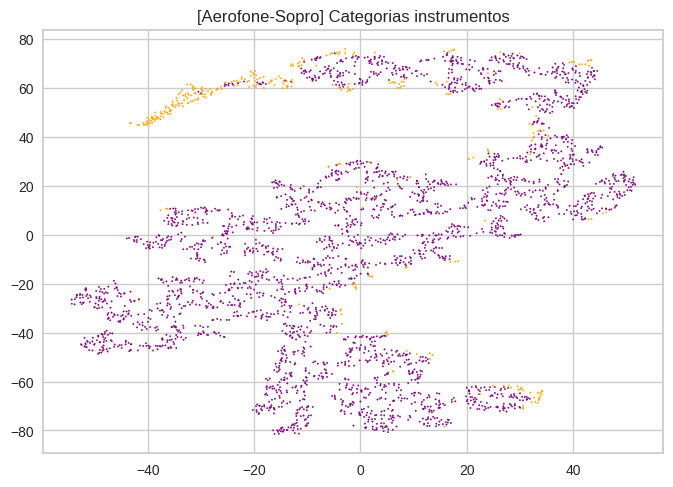

In [ ]:
graphic_anomalies(df_aerofone_sopro.drop(columns=["instrumento", "cat_inst"]), '[Aerofone-Sopro] Categorias instrumentos')

In [ ]:
df_aerofone_sopro = remove_outilers(df_aerofone_sopro.drop(columns=["instrumento", "cat_inst"]))
df_aerofone_sopro

,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,mfcc0,...,spectral_band4,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,label_inst,label_cat_inst
0,0.010380,0.038218,0.513887,0.581963,0.434641,0.293949,0.317826,0.271148,0.548258,-24.170067,...,3409.640722,2600.055158,1.098243,5260.821321,-44.640682,-30.202150,0.149672,33095,0,0
1,0.084643,-0.035337,0.175587,0.429345,0.840043,0.384524,0.282545,0.346341,0.482365,-90.556145,...,3516.595715,2385.271420,1.360742,5225.124166,-46.575737,-59.323132,0.112181,24785,0,0
2,-0.030127,0.082404,0.453814,0.219808,0.228484,0.446050,0.178916,0.250981,0.327460,-106.124260,...,3256.491175,2069.850731,1.343197,4287.155824,-56.276707,-71.512909,0.096007,21230,0,0
3,0.157274,-0.066099,0.209729,0.338755,0.660264,0.256625,0.275209,0.180417,0.399448,-66.319801,...,3855.791675,2903.979876,1.218963,6751.133809,-42.723160,-44.649315,0.144010,31836,0,0
4,-0.049096,-0.029067,0.484400,0.334572,0.441629,0.679485,0.382958,0.326033,0.205775,-226.263824,...,2883.225952,1251.374287,1.339527,2263.034730,-62.227947,-78.196365,0.059804,13214,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7161,0.031326,0.036042,0.281165,0.467478,0.383710,0.385898,0.358991,0.379168,0.286116,-221.750122,...,2040.836138,896.653459,1.242603,1782.859289,-42.632786,-42.830780,0.041767,9231,16,1
7162,0.024069,-0.064162,0.038717,0.051984,0.156484,0.528343,0.865360,0.228249,0.063890,-213.012329,...,2528.740114,1280.731144,1.535133,1930.644010,-52.891537,-79.643761,0.078466,17360,16,1
7163,0.046916,0.068088,0.517141,0.282860,0.547268,0.444383,0.516097,0.406917,0.322084,-35.486549,...,3643.088516,2309.708871,1.049440,5199.019529,-37.911655,-57.435429,0.095421,21114,16,1
7164,0.109233,0.002179,0.271734,0.290186,0.454663,0.332584,0.266866,0.341721,0.481044,-134.787796,...,3440.696663,2370.998419,1.259253,5153.205266,-53.025776,-79.120621,0.126226,27933,16,1


- Treinamento de Modelo

In [ ]:
train_models(
    X= df_aerofone_sopro.drop(columns=["label_inst", "label_cat_inst"]),
    y= df_aerofone_sopro.label_cat_inst.to_frame()
)

Acuracia do modelo GaussianNB() do Fold 0: 0.4049586776859504
Acuracia do modelo GaussianNB() do Fold 1: 0.5917355371900826
Acuracia do modelo GaussianNB() do Fold 2: 0.6330578512396694
Acuracia do modelo GaussianNB() do Fold 3: 0.7549668874172185
Acuracia do modelo GaussianNB() do Fold 4: 0.6688741721854304
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.4214876033057851
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.5867768595041323
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.6396694214876033
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.6804635761589404
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.6043046357615894
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.47768595041322315
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.5785123966942148
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.6181818181818182
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.597682119205298
Acuracia do modelo DecisionTreeCla

{'Naive Bayes': 0.6107186251436703,
 'KNN': 0.5865404192436101,
 'Arvore de Decisão': 0.576597887362487,
 'Floresta Aleatoria': 0.6434278364621531,
 'HistGradientBoosting': 0.6530151606370751,
 'LIGHTGBM': 0.6622773794537793,
 'MLP': 0.554411909583493,
 'XGB': 0.6566487876963494,
 'SVC': 0.6325532264243885}

In [ ]:
keys = le.classes_
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))
print(dictionary)

{'aerofone': 0, 'sopro': 1}


- Matriz de confusão

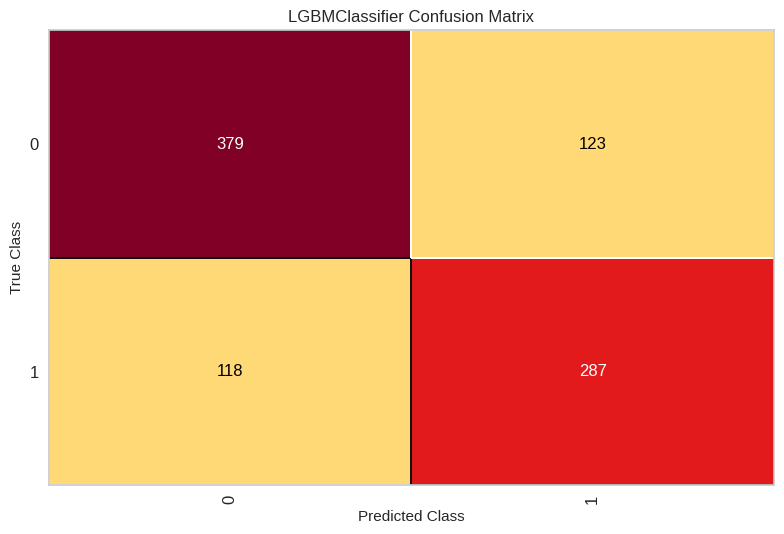

<AxesSubplot: title={'center': 'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
X = df_aerofone_sopro.drop(columns=["label_inst", "label_cat_inst"])
y = df_aerofone_sopro.label_cat_inst

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

cm = ConfusionMatrix(LGBMClassifier(), classes=[0,1])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

### Aerofone e percusão

In [ ]:
df_aerofone_percusao = df_cat_inst[df_cat_inst["cat_inst"].isin(["aerofone", "percusao"])]
df_aerofone_percusao["label_cat_inst"] = le.fit_transform(df_aerofone_percusao.cat_inst)
df_aerofone_percusao

,cat_inst,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,...,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,instrumento,label_inst,label_cat_inst
0,aerofone,0.010380,0.038218,0.513887,0.581963,0.434641,0.293949,0.317826,0.271148,0.548258,...,2600.055158,1.098243,5260.821321,-44.640682,-30.202150,0.149672,33095,accordion,0,0
1,aerofone,0.084643,-0.035337,0.175587,0.429345,0.840043,0.384524,0.282545,0.346341,0.482365,...,2385.271420,1.360742,5225.124166,-46.575737,-59.323132,0.112181,24785,accordion,0,0
2,aerofone,-0.030127,0.082404,0.453814,0.219808,0.228484,0.446050,0.178916,0.250981,0.327460,...,2069.850731,1.343197,4287.155824,-56.276707,-71.512909,0.096007,21230,accordion,0,0
3,aerofone,0.157274,-0.066099,0.209729,0.338755,0.660264,0.256625,0.275209,0.180417,0.399448,...,2903.979876,1.218963,6751.133809,-42.723160,-44.649315,0.144010,31836,accordion,0,0
4,aerofone,-0.049096,-0.029067,0.484400,0.334572,0.441629,0.679485,0.382958,0.326033,0.205775,...,1251.374287,1.339527,2263.034730,-62.227947,-78.196365,0.059804,13214,accordion,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4581,percusao,0.064085,0.031877,0.088719,0.110646,0.159631,0.303337,0.233713,0.293759,0.225420,...,1950.192940,1.101535,2585.158459,-50.985691,-72.046715,0.160147,35457,mallet_percussion,9,1
4582,percusao,0.264473,-0.245898,0.214395,0.094173,0.177360,0.087018,0.063969,0.138096,0.353633,...,1984.641346,1.996110,4595.240504,-66.942772,-78.150574,0.064426,14272,mallet_percussion,9,1
4583,percusao,0.087865,-0.048417,0.321572,0.221088,0.240128,0.374176,0.547956,0.418325,0.338949,...,3307.151107,1.378473,6980.305045,-56.667892,-75.132233,0.158234,35032,mallet_percussion,9,1
4584,percusao,0.432549,0.102409,0.204631,0.283638,0.785254,0.440283,0.356656,0.148266,0.208002,...,1533.762409,1.141370,2913.027706,-68.506294,-79.922241,0.079375,17537,mallet_percussion,9,1


- Tratar Outilers

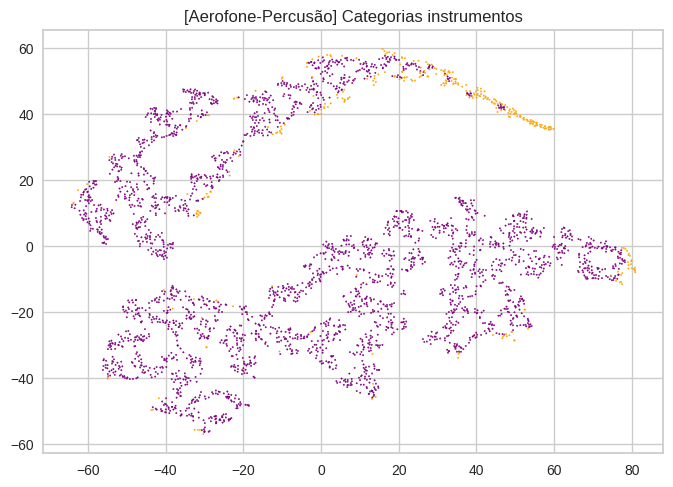

In [ ]:
graphic_anomalies(df_aerofone_percusao.drop(columns=["instrumento", "cat_inst"]), '[Aerofone-Percusão] Categorias instrumentos')

In [ ]:
df_aerofone_percusao = remove_outilers(df_aerofone_percusao.drop(columns=["instrumento", "cat_inst"]))
df_aerofone_percusao

,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,mfcc0,...,spectral_band4,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,label_inst,label_cat_inst
0,0.010380,0.038218,0.513887,0.581963,0.434641,0.293949,0.317826,0.271148,0.548258,-24.170067,...,3409.640722,2600.055158,1.098243,5260.821321,-44.640682,-30.202150,0.149672,33095,0,0
1,0.084643,-0.035337,0.175587,0.429345,0.840043,0.384524,0.282545,0.346341,0.482365,-90.556145,...,3516.595715,2385.271420,1.360742,5225.124166,-46.575737,-59.323132,0.112181,24785,0,0
2,-0.030127,0.082404,0.453814,0.219808,0.228484,0.446050,0.178916,0.250981,0.327460,-106.124260,...,3256.491175,2069.850731,1.343197,4287.155824,-56.276707,-71.512909,0.096007,21230,0,0
3,0.157274,-0.066099,0.209729,0.338755,0.660264,0.256625,0.275209,0.180417,0.399448,-66.319801,...,3855.791675,2903.979876,1.218963,6751.133809,-42.723160,-44.649315,0.144010,31836,0,0
4,-0.049096,-0.029067,0.484400,0.334572,0.441629,0.679485,0.382958,0.326033,0.205775,-226.263824,...,2883.225952,1251.374287,1.339527,2263.034730,-62.227947,-78.196365,0.059804,13214,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4579,-0.055175,0.223582,0.250344,0.144348,0.358254,0.466781,0.185795,0.219963,0.178048,-251.803406,...,2624.499946,1354.596953,2.051116,2461.155187,-68.754555,-77.429588,0.070300,15541,9,1
4580,0.113357,0.063352,0.217164,0.143870,0.322778,0.112114,0.120639,0.256409,0.116839,-342.947083,...,3775.912095,1661.007320,1.292728,3554.577269,-43.292679,-54.901520,0.055292,12232,9,1
4582,0.264473,-0.245898,0.214395,0.094173,0.177360,0.087018,0.063969,0.138096,0.353633,-242.346970,...,3803.817212,1984.641346,1.996110,4595.240504,-66.942772,-78.150574,0.064426,14272,9,1
4583,0.087865,-0.048417,0.321572,0.221088,0.240128,0.374176,0.547956,0.418325,0.338949,-51.251186,...,3608.456357,3307.151107,1.378473,6980.305045,-56.667892,-75.132233,0.158234,35032,9,1


- Treinamento de Modelo

In [ ]:
train_models(
    X= df_aerofone_percusao.drop(columns=["label_inst", "label_cat_inst"]),
    y= df_aerofone_percusao.label_cat_inst.to_frame()
)

Acuracia do modelo GaussianNB() do Fold 0: 0.5637583892617449
Acuracia do modelo GaussianNB() do Fold 1: 0.6812080536912751
Acuracia do modelo GaussianNB() do Fold 2: 0.7210084033613445
Acuracia do modelo GaussianNB() do Fold 3: 0.7075630252100841
Acuracia do modelo GaussianNB() do Fold 4: 0.6823529411764706
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.5704697986577181
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.6510067114093959
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.6588235294117647
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.66890756302521
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.6504201680672269
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.6208053691275168
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.6711409395973155
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.6672268907563025
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.6621848739495798
Acuracia do modelo DecisionTreeClass

{'Naive Bayes': 0.6711781625401839,
 'KNN': 0.639925554114263,
 'Arvore de Decisão': 0.6583892617449664,
 'Floresta Aleatoria': 0.7154864361852123,
 'HistGradientBoosting': 0.7282448818453556,
 'LIGHTGBM': 0.7336151373300999,
 'MLP': 0.6214562066437312,
 'XGB': 0.7289188427048672,
 'SVC': 0.6597580508713553}

In [ ]:
keys = le.classes_
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))
print(dictionary)

{'aerofone': 0, 'percusao': 1}


- Matriz de Confusão

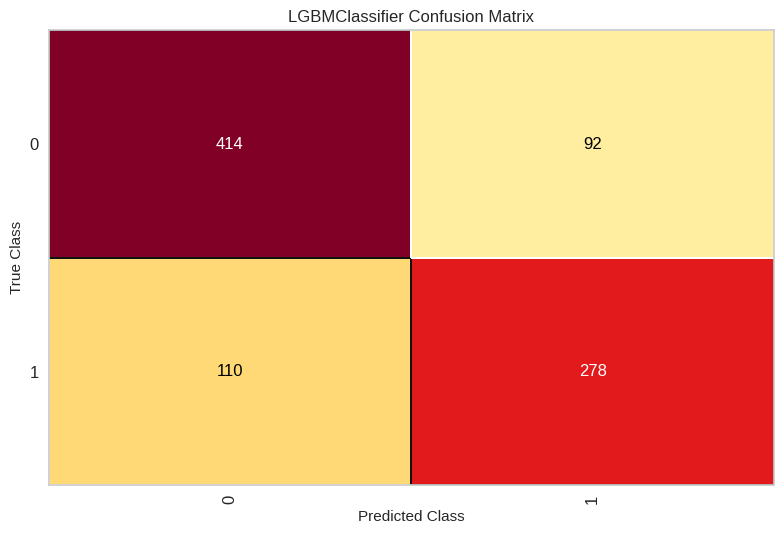

<AxesSubplot: title={'center': 'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
X = df_aerofone_percusao.drop(columns=["label_inst", "label_cat_inst"])
y = df_aerofone_percusao.label_cat_inst

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

cm = ConfusionMatrix(LGBMClassifier(), classes=[0,1])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

### Sopro e Percusão

In [ ]:
df_sopro_percusao = df_cat_inst[df_cat_inst["cat_inst"].isin(["sopro", "percusao"])]
df_sopro_percusao["label_cat_inst"] = le.fit_transform(df_sopro_percusao.cat_inst)
df_sopro_percusao

,cat_inst,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,...,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,instrumento,label_inst,label_cat_inst
2027,percusao,0.040087,0.116203,0.409334,0.260820,0.298635,0.223068,0.472596,0.682380,0.315802,...,2843.107702,0.915473,6288.444728,-72.321693,-79.942192,0.106036,23418,cymbals,5,0
2028,percusao,0.064332,-0.023445,0.221986,0.318158,0.420399,0.800723,0.699277,0.292424,0.310495,...,2549.517812,1.755609,4183.087002,-47.144733,-65.961197,0.182486,40358,cymbals,5,0
2029,percusao,-0.039875,0.021506,0.597219,0.522248,0.357256,0.306705,0.454092,0.676822,0.459109,...,2543.370274,0.869033,4545.004690,-59.076328,-70.129898,0.152626,33743,cymbals,5,0
2030,percusao,-0.039822,0.028304,0.621655,0.511336,0.348413,0.316168,0.392748,0.568508,0.565586,...,2479.813426,1.396642,5702.476809,-63.114140,-71.209488,0.082574,18250,cymbals,5,0
2031,percusao,0.098013,0.027428,0.383891,0.186740,0.131834,0.186899,0.345623,0.210410,0.242533,...,2037.566496,1.731518,4412.483063,-56.386051,-59.750889,0.079232,17508,cymbals,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7161,sopro,0.031326,0.036042,0.281165,0.467478,0.383710,0.385898,0.358991,0.379168,0.286116,...,896.653459,1.242603,1782.859289,-42.632786,-42.830780,0.041767,9231,trumpet,16,1
7162,sopro,0.024069,-0.064162,0.038717,0.051984,0.156484,0.528343,0.865360,0.228249,0.063890,...,1280.731144,1.535133,1930.644010,-52.891537,-79.643761,0.078466,17360,trumpet,16,1
7163,sopro,0.046916,0.068088,0.517141,0.282860,0.547268,0.444383,0.516097,0.406917,0.322084,...,2309.708871,1.049440,5199.019529,-37.911655,-57.435429,0.095421,21114,trumpet,16,1
7164,sopro,0.109233,0.002179,0.271734,0.290186,0.454663,0.332584,0.266866,0.341721,0.481044,...,2370.998419,1.259253,5153.205266,-53.025776,-79.120621,0.126226,27933,trumpet,16,1


- Tratar outilers

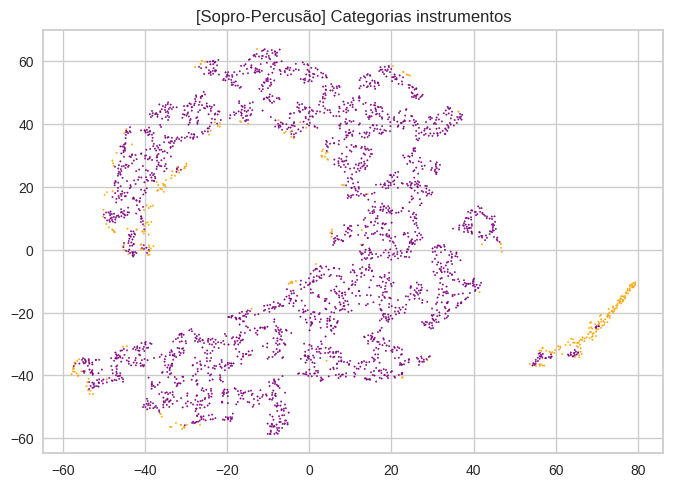

In [ ]:
graphic_anomalies(df_sopro_percusao.drop(columns=["instrumento", "cat_inst"]), '[Sopro-Percusão] Categorias instrumentos')

In [ ]:
df_sopro_percusao = remove_outilers(df_sopro_percusao.drop(columns=["instrumento", "cat_inst"]))
df_sopro_percusao

,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,mfcc0,...,spectral_band4,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,label_inst,label_cat_inst
2027,0.040087,0.116203,0.409334,0.260820,0.298635,0.223068,0.472596,0.682380,0.315802,-324.986115,...,3634.193997,2843.107702,0.915473,6288.444728,-72.321693,-79.942192,0.106036,23418,5,0
2028,0.064332,-0.023445,0.221986,0.318158,0.420399,0.800723,0.699277,0.292424,0.310495,-92.665298,...,2783.919958,2549.517812,1.755609,4183.087002,-47.144733,-65.961197,0.182486,40358,5,0
2029,-0.039875,0.021506,0.597219,0.522248,0.357256,0.306705,0.454092,0.676822,0.459109,-167.831787,...,3093.350146,2543.370274,0.869033,4545.004690,-59.076328,-70.129898,0.152626,33743,5,0
2030,-0.039822,0.028304,0.621655,0.511336,0.348413,0.316168,0.392748,0.568508,0.565586,-389.340240,...,3709.821567,2479.813426,1.396642,5702.476809,-63.114140,-71.209488,0.082574,18250,5,0
2031,0.098013,0.027428,0.383891,0.186740,0.131834,0.186899,0.345623,0.210410,0.242533,-169.979294,...,3467.632804,2037.566496,1.731518,4412.483063,-56.386051,-59.750889,0.079232,17508,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7161,0.031326,0.036042,0.281165,0.467478,0.383710,0.385898,0.358991,0.379168,0.286116,-221.750122,...,2040.836138,896.653459,1.242603,1782.859289,-42.632786,-42.830780,0.041767,9231,16,1
7162,0.024069,-0.064162,0.038717,0.051984,0.156484,0.528343,0.865360,0.228249,0.063890,-213.012329,...,2528.740114,1280.731144,1.535133,1930.644010,-52.891537,-79.643761,0.078466,17360,16,1
7163,0.046916,0.068088,0.517141,0.282860,0.547268,0.444383,0.516097,0.406917,0.322084,-35.486549,...,3643.088516,2309.708871,1.049440,5199.019529,-37.911655,-57.435429,0.095421,21114,16,1
7164,0.109233,0.002179,0.271734,0.290186,0.454663,0.332584,0.266866,0.341721,0.481044,-134.787796,...,3440.696663,2370.998419,1.259253,5153.205266,-53.025776,-79.120621,0.126226,27933,16,1


- Treinamento de Modelo

In [ ]:
train_models(
    X= df_sopro_percusao.drop(columns=["label_inst", "label_cat_inst"]),
    y= df_sopro_percusao.label_cat_inst.to_frame()
)

Acuracia do modelo GaussianNB() do Fold 0: 0.8035087719298246
Acuracia do modelo GaussianNB() do Fold 1: 0.743859649122807
Acuracia do modelo GaussianNB() do Fold 2: 0.6
Acuracia do modelo GaussianNB() do Fold 3: 0.2807017543859649
Acuracia do modelo GaussianNB() do Fold 4: 0.41403508771929826
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.5754385964912281
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.5245614035087719
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.5421052631578948
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.443859649122807
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.47368421052631576
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.6105263157894737
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.5912280701754385
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.6087719298245614
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.4543859649122807
Acuracia do modelo DecisionTreeClassifier() do Fo

{'Naive Bayes': 0.5684210526315789,
 'KNN': 0.5119298245614036,
 'Arvore de Decisão': 0.5498245614035088,
 'Floresta Aleatoria': 0.62140350877193,
 'HistGradientBoosting': 0.620701754385965,
 'LIGHTGBM': 0.6294736842105263,
 'MLP': 0.5498245614035088,
 'XGB': 0.6238596491228071,
 'SVC': 0.5733333333333334}

In [ ]:
keys = le.classes_
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))
print(dictionary)

{'percusao': 0, 'sopro': 1}


- Matriz de confusão

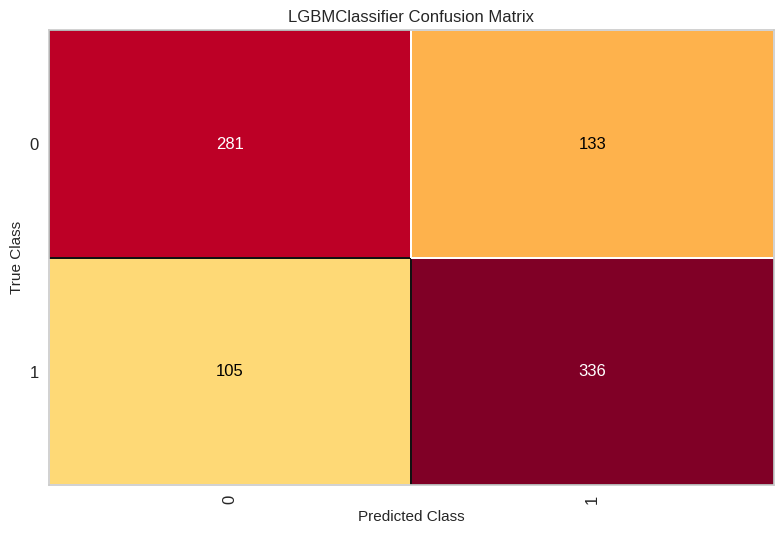

<AxesSubplot: title={'center': 'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
X = df_sopro_percusao.drop(columns=["label_inst", "label_cat_inst"])
y = df_sopro_percusao.label_cat_inst

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

cm = ConfusionMatrix(LGBMClassifier(), classes=[0,1])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

### Sopro e corda

In [ ]:
df_sopro_corda = df_cat_inst[df_cat_inst["cat_inst"].isin(["sopro", "corda"])]
df_sopro_corda["label_cat_inst"] = le.fit_transform(df_sopro_corda.cat_inst)


- Tratar Outilers

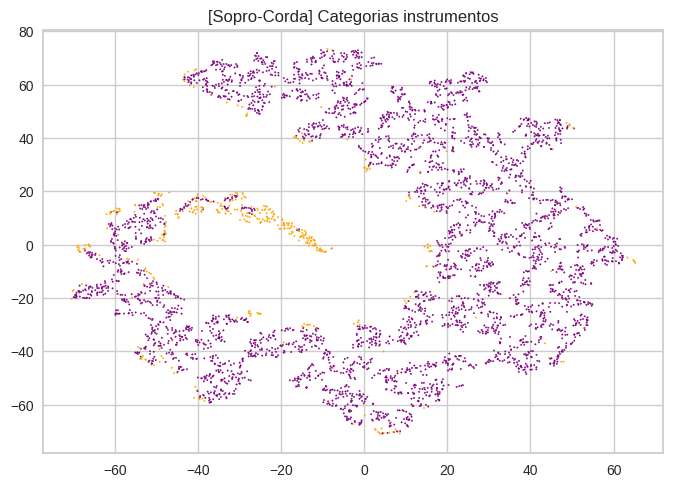

In [ ]:
graphic_anomalies(
    df_sopro_corda.drop(columns=["instrumento", "cat_inst"]), 
    '[Sopro-Corda] Categorias instrumentos'
)

In [ ]:
df_sopro_corda = remove_outilers(df_sopro_corda.drop(columns=["instrumento", "cat_inst"]))
df_sopro_corda

,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,mfcc0,...,spectral_band4,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,label_inst,label_cat_inst
1875,0.060383,0.017910,0.319152,0.367783,0.465361,0.399524,0.357706,0.343498,0.282757,8.203455,...,3239.194180,2328.546611,1.093156,5092.952266,-52.844872,-68.585281,0.105613,23362,4,1
1877,-0.102407,-0.053821,0.007352,0.016456,0.251515,0.982690,0.649991,0.123668,0.015163,-170.240860,...,3532.073752,1571.665681,0.959548,3635.089465,-61.261280,-78.551147,0.036253,8015,4,1
1879,0.137429,-0.165245,0.004996,0.004829,0.009536,0.313501,1.000000,0.247865,0.029246,-200.479965,...,3529.484253,1302.617113,0.927032,2510.017073,-61.047974,-77.810928,0.029619,6548,4,1
1880,0.236781,-0.104811,0.360671,0.143619,0.062925,0.141207,0.458111,0.159797,0.037194,-225.307404,...,2379.025103,1104.750913,1.166350,1975.259208,-66.297119,-78.115021,0.066677,14813,4,1
1881,0.251144,0.276060,0.757470,0.276578,0.013081,0.137285,0.914434,0.177750,0.035843,-196.740616,...,2551.677641,930.040460,0.972946,1324.891525,-62.295158,-79.964806,0.063943,14130,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8015,0.155398,0.202623,0.279203,0.175173,0.329897,0.101118,0.119236,0.150895,0.161468,-106.568298,...,3026.877791,2266.961445,1.172216,4213.738093,-42.284138,-79.955719,0.133785,29606,18,0
8018,0.181463,-0.109062,0.259089,0.054198,0.135665,0.120070,0.198278,0.268761,0.094458,-233.943954,...,2498.332214,1356.828177,0.969832,2408.271439,-62.397167,-78.355164,0.083315,18430,18,0
8019,0.051950,0.691044,0.773323,0.582712,0.532384,0.274606,0.127275,0.109617,0.158079,-260.673492,...,1906.686246,658.017342,1.227272,1367.932950,-35.302883,-68.164001,0.019043,4212,18,0
8021,0.093624,-0.031124,0.253249,0.321181,0.309254,0.265595,0.265015,0.155659,0.181344,-128.199768,...,3174.287104,1421.358194,1.173742,2751.578644,-48.512993,-66.277359,0.065123,14407,18,0


- Treinamento de Modelo

In [ ]:
train_models(
    X= df_sopro_corda.drop(columns=["label_inst", "label_cat_inst"]),
    y= df_sopro_corda.label_cat_inst.to_frame()
)

Acuracia do modelo GaussianNB() do Fold 0: 0.5319693094629157
Acuracia do modelo GaussianNB() do Fold 1: 0.7404092071611253
Acuracia do modelo GaussianNB() do Fold 2: 0.736235595390525
Acuracia do modelo GaussianNB() do Fold 3: 0.5416133162612036
Acuracia do modelo GaussianNB() do Fold 4: 0.352112676056338
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.5754475703324808
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.6777493606138107
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.6645326504481434
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.5928297055057619
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.49167733674775926
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.5741687979539642
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.6342710997442456
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.618437900128041
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.5620998719590269
Acuracia do modelo DecisionTreeClass

{'Naive Bayes': 0.5804680208664216,
 'KNN': 0.6004473247295912,
 'Arvore de Decisão': 0.5725458540594883,
 'Floresta Aleatoria': 0.6452226963267632,
 'HistGradientBoosting': 0.6457355151602477,
 'LIGHTGBM': 0.6424107069761045,
 'MLP': 0.6337402700321905,
 'XGB': 0.6393406708561062,
 'SVC': 0.631423416106965}

In [ ]:
keys = le.classes_
values = le.transform(le.classes_)
dictionary = dict(zip(keys, values))
print(dictionary)

{'corda': 0, 'sopro': 1}


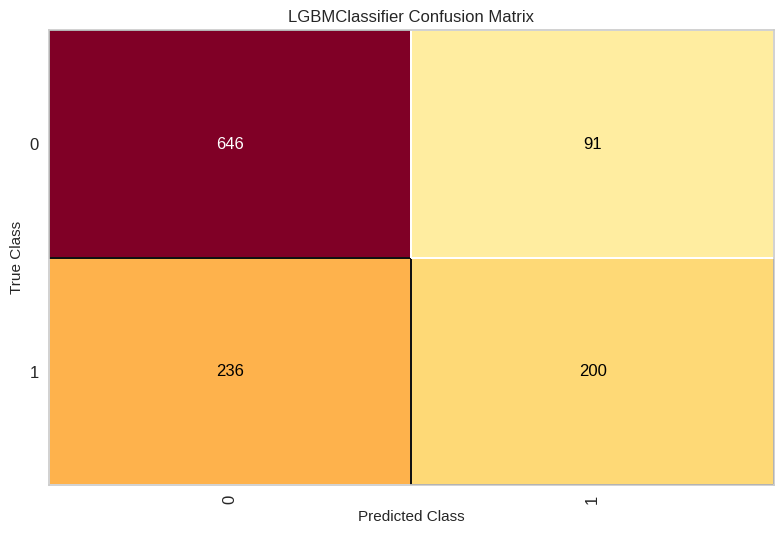

<AxesSubplot: title={'center': 'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
X = df_sopro_corda.drop(columns=["label_inst", "label_cat_inst"])
y = df_sopro_corda.label_cat_inst

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

cm = ConfusionMatrix(LGBMClassifier(), classes=[0,1])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()

### Corda Percusão

In [ ]:
df_corda_percusao = df_cat_inst[df_cat_inst["cat_inst"].isin(["corda", "percusao"])]
df_corda_percusao["label_cat_inst"] = le.fit_transform(df_corda_percusao.cat_inst)
df_corda_percusao

,cat_inst,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,...,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,instrumento,label_inst,label_cat_inst
2027,percusao,0.040087,0.116203,0.409334,0.260820,0.298635,0.223068,0.472596,0.682380,0.315802,...,2843.107702,0.915473,6288.444728,-72.321693,-79.942192,0.106036,23418,cymbals,5,1
2028,percusao,0.064332,-0.023445,0.221986,0.318158,0.420399,0.800723,0.699277,0.292424,0.310495,...,2549.517812,1.755609,4183.087002,-47.144733,-65.961197,0.182486,40358,cymbals,5,1
2029,percusao,-0.039875,0.021506,0.597219,0.522248,0.357256,0.306705,0.454092,0.676822,0.459109,...,2543.370274,0.869033,4545.004690,-59.076328,-70.129898,0.152626,33743,cymbals,5,1
2030,percusao,-0.039822,0.028304,0.621655,0.511336,0.348413,0.316168,0.392748,0.568508,0.565586,...,2479.813426,1.396642,5702.476809,-63.114140,-71.209488,0.082574,18250,cymbals,5,1
2031,percusao,0.098013,0.027428,0.383891,0.186740,0.131834,0.186899,0.345623,0.210410,0.242533,...,2037.566496,1.731518,4412.483063,-56.386051,-59.750889,0.079232,17508,cymbals,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8019,corda,0.051950,0.691044,0.773323,0.582712,0.532384,0.274606,0.127275,0.109617,0.158079,...,658.017342,1.227272,1367.932950,-35.302883,-68.164001,0.019043,4212,violin,18,0
8020,corda,0.015595,-0.058762,0.120028,0.238263,0.234643,0.267743,0.228591,0.260930,0.267262,...,3573.542978,1.354204,6552.813508,-43.596504,-73.498703,0.230540,50962,violin,18,0
8021,corda,0.093624,-0.031124,0.253249,0.321181,0.309254,0.265595,0.265015,0.155659,0.181344,...,1421.358194,1.173742,2751.578644,-48.512993,-66.277359,0.065123,14407,violin,18,0
8022,corda,0.004588,-0.009204,0.124913,0.174113,0.185558,0.169614,0.149416,0.075544,0.081894,...,3720.081212,1.332893,6207.732687,-37.720039,-72.552101,0.241853,53491,violin,18,0


- Tratamento Outilers

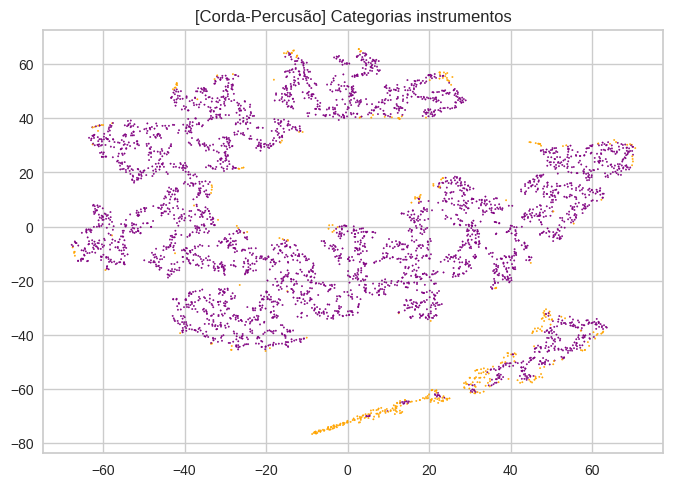

In [ ]:
graphic_anomalies(df_corda_percusao.drop(columns=["instrumento", "cat_inst"]), '[Corda-Percusão] Categorias instrumentos')

In [ ]:
df_corda_percusao = remove_outilers(df_corda_percusao.drop(columns=["instrumento", "cat_inst"]))
df_corda_percusao

,tonnetz0,tonnetz1,chroma1,chroma2,chroma3,chroma4,chroma5,chroma6,chroma7,mfcc0,...,spectral_band4,spectral_centroid,spectral_onset,spectral_rolloff,spectogram,mel_spectogram,zero_crossing_rate,zero_crossing,label_inst,label_cat_inst
2027,0.040087,0.116203,0.409334,0.260820,0.298635,0.223068,0.472596,0.682380,0.315802,-324.986115,...,3634.193997,2843.107702,0.915473,6288.444728,-72.321693,-79.942192,0.106036,23418,5,1
2028,0.064332,-0.023445,0.221986,0.318158,0.420399,0.800723,0.699277,0.292424,0.310495,-92.665298,...,2783.919958,2549.517812,1.755609,4183.087002,-47.144733,-65.961197,0.182486,40358,5,1
2029,-0.039875,0.021506,0.597219,0.522248,0.357256,0.306705,0.454092,0.676822,0.459109,-167.831787,...,3093.350146,2543.370274,0.869033,4545.004690,-59.076328,-70.129898,0.152626,33743,5,1
2030,-0.039822,0.028304,0.621655,0.511336,0.348413,0.316168,0.392748,0.568508,0.565586,-389.340240,...,3709.821567,2479.813426,1.396642,5702.476809,-63.114140,-71.209488,0.082574,18250,5,1
2031,0.098013,0.027428,0.383891,0.186740,0.131834,0.186899,0.345623,0.210410,0.242533,-169.979294,...,3467.632804,2037.566496,1.731518,4412.483063,-56.386051,-59.750889,0.079232,17508,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8016,0.066705,-0.239727,0.177657,0.249958,0.202065,0.227559,0.358576,0.191313,0.535777,-163.197540,...,3258.026601,2049.088272,1.239214,3472.241494,-45.379463,-80.000000,0.128462,28414,18,0
8018,0.181463,-0.109062,0.259089,0.054198,0.135665,0.120070,0.198278,0.268761,0.094458,-233.943954,...,2498.332214,1356.828177,0.969832,2408.271439,-62.397167,-78.355164,0.083315,18430,18,0
8019,0.051950,0.691044,0.773323,0.582712,0.532384,0.274606,0.127275,0.109617,0.158079,-260.673492,...,1906.686246,658.017342,1.227272,1367.932950,-35.302883,-68.164001,0.019043,4212,18,0
8021,0.093624,-0.031124,0.253249,0.321181,0.309254,0.265595,0.265015,0.155659,0.181344,-128.199768,...,3174.287104,1421.358194,1.173742,2751.578644,-48.512993,-66.277359,0.065123,14407,18,0


- Treinamento de Modelos

In [ ]:
train_models(
    X = df_sopro_corda.drop(columns=["label_inst", "label_cat_inst"]),
    y = df_sopro_corda.label_cat_inst.to_frame()
)

Acuracia do modelo GaussianNB() do Fold 0: 0.5319693094629157
Acuracia do modelo GaussianNB() do Fold 1: 0.7404092071611253
Acuracia do modelo GaussianNB() do Fold 2: 0.736235595390525
Acuracia do modelo GaussianNB() do Fold 3: 0.5416133162612036
Acuracia do modelo GaussianNB() do Fold 4: 0.352112676056338
Acuracia do modelo KNeighborsClassifier() do Fold 0: 0.5754475703324808
Acuracia do modelo KNeighborsClassifier() do Fold 1: 0.6777493606138107
Acuracia do modelo KNeighborsClassifier() do Fold 2: 0.6645326504481434
Acuracia do modelo KNeighborsClassifier() do Fold 3: 0.5928297055057619
Acuracia do modelo KNeighborsClassifier() do Fold 4: 0.49167733674775926
Acuracia do modelo DecisionTreeClassifier() do Fold 0: 0.571611253196931
Acuracia do modelo DecisionTreeClassifier() do Fold 1: 0.6355498721227621
Acuracia do modelo DecisionTreeClassifier() do Fold 2: 0.6350832266325224
Acuracia do modelo DecisionTreeClassifier() do Fold 3: 0.5518565941101152
Acuracia do modelo DecisionTreeClass

{'Naive Bayes': 0.5804680208664216,
 'KNN': 0.6004473247295912,
 'Arvore de Decisão': 0.572290099583785,
 'Floresta Aleatoria': 0.6365198398014219,
 'HistGradientBoosting': 0.6457355151602477,
 'LIGHTGBM': 0.6424107069761045,
 'MLP': 0.6214388399684319,
 'XGB': 0.6393406708561062,
 'SVC': 0.631423416106965}

- Matriz de confusão

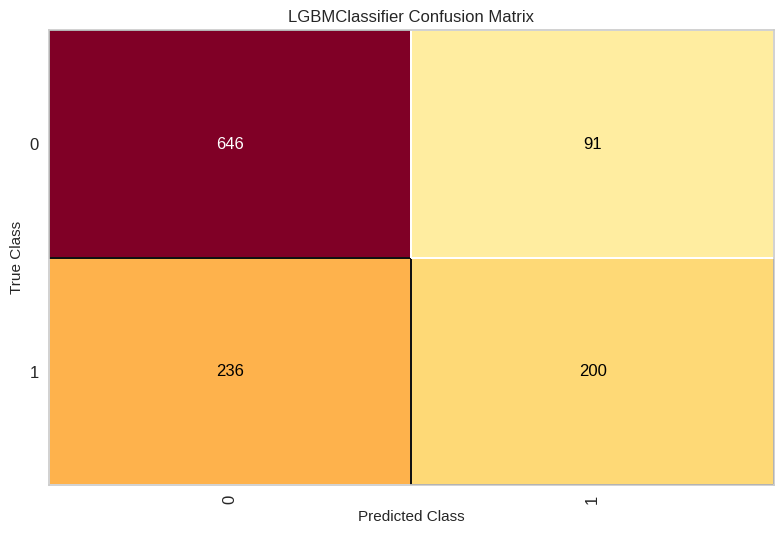

<AxesSubplot: title={'center': 'LGBMClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [ ]:
X = df_sopro_corda.drop(columns=["label_inst", "label_cat_inst"])
y = df_sopro_corda.label_cat_inst

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

cm = ConfusionMatrix(LGBMClassifier(), classes=[0,1])
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.show()